In [6]:
from src.datasetSetup import srediDataset
srediDataset("datasetovi", "dataset1.zip")

Skidanje dataseta, unzipovanje, organizovanje (iznad) 

Loading data i ucitavanje pretreniranog modela, detektovanje objekata na slici PRE fine-tuninga

c:\Users\Andjela\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Andjela\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Label index 37 out of range for CLASSES list.
Labels: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  9, 37,  1, 84,  1, 43,  1, 72, 43, 10,  8,  1, 76,
        43, 38,  1, 76,  1, 43, 43,  1, 62, 73,  1,  1, 73,  1,  1, 62,  1, 43,
         1,  1,  1, 43])
Classes length: 21
Label index 84 out of range for CLASSES list.
Labels: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  9, 37,  1, 84,  1, 43,  1, 72, 43, 10,  8,  1, 76,
        43, 38,  1, 76,  1, 43, 43,  1, 62, 73,  1,  1, 73,  1,  1, 62,  1, 43,
         1,  1,  1, 43])
Classes length: 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


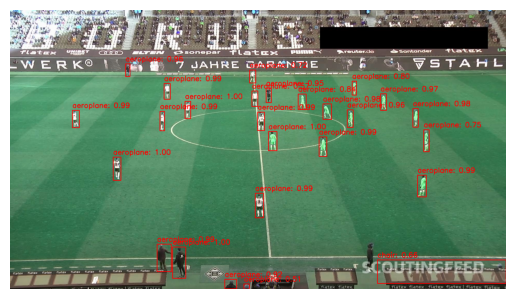

Label index 37 out of range for CLASSES list.
Labels: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1, 37,  8,  1, 16,  1, 43,  1,  1,  1, 76, 84,  1,
         1,  9, 73,  1, 15, 33,  1, 72])
Classes length: 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


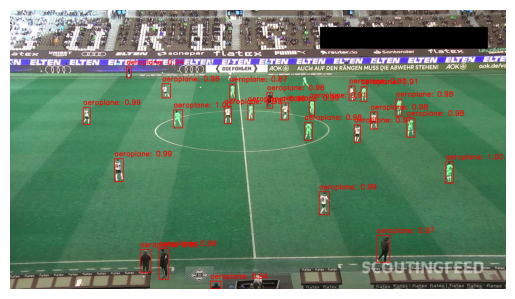

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


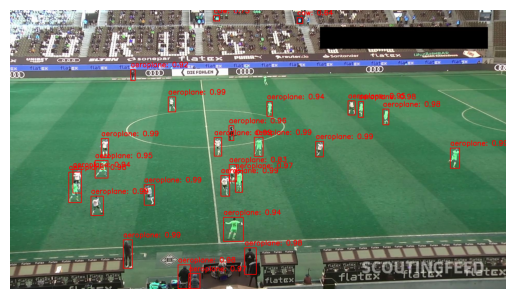

KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt
import torchvision
import cv2
from src.customDataset import CustomVOCDataset
from src.modelFunkcije import *
from src.utils import *

# Definisemo transformations
transform = T.Compose([T.ToTensor()])

# Kreiramo dataset instancu i dataloader
dataset = CustomVOCDataset(root='datasetovi/dataset1.zip_sredjen/valid', CLASSES=classes, transforms=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

# Ucitamo pretrenirani Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Pokrenemo detektovanje nad datasetom koji smo load-ovali
for images, targets in data_loader:
    images = list(img.to(device) for img in images)

    with torch.no_grad():
        prediction = model(images)

    for img, pred in zip(images, prediction):
        plot_image_with_boxes(img, pred['boxes'], pred['labels'], pred['scores'], classes)

Loading data i fine-tuning modela

In [4]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from src.customDataset import CustomVOCDataset
from src.modelFunkcije import *
from src.utils import *

# Definisemo transformations
transform = T.Compose([T.ToTensor()])

def my_collate_fn(x): return tuple(zip(*x))

# Kreiramo dataset instancu i dataloader
dataset = CustomVOCDataset(root='datasetovi/dataset1.zip_sredjen/train', CLASSES=CLASSES, transforms=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=my_collate_fn)

# Glavni deo koda za trening
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_classes)
model.to(device)

train_model(model, data_loader, device, num_epochs)

save_directory = 'finetune modeli'
os.makedirs(save_directory, exist_ok=True)

# Cuva model
torch.save(model.state_dict(), os.path.join(save_directory, 'frcnn_custom_final.pth'))


Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #0 loss: 19.22104573249817
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #1 loss: 14.15296059846878
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #2 loss: 11.12207841873169
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #3 loss: 9.353618562221527
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #4 loss: 8.10607522726059
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #5 loss: 7.586801469326019
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #6 loss: 7.506744205951691
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #7 loss: 7.3746925592422485
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #8 loss: 7.334650963544846
Skipping invalid bounding box: [1533, 706, 1533, 706]
Epoch #9 loss: 7.340187102556229


Plotovanje rezultata

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


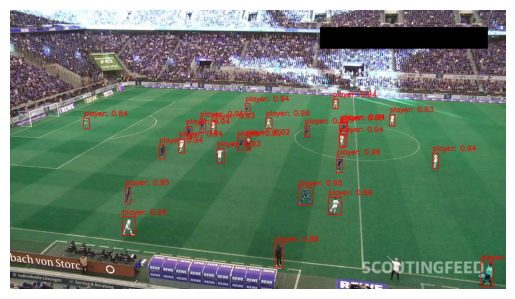

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


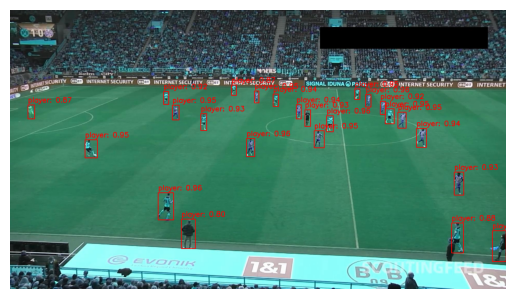

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


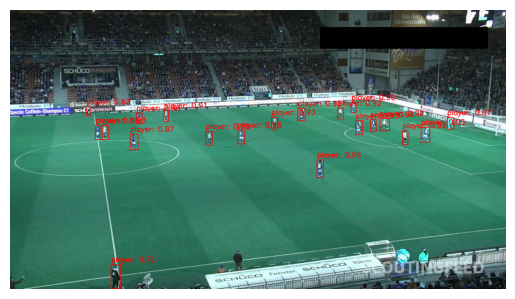

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


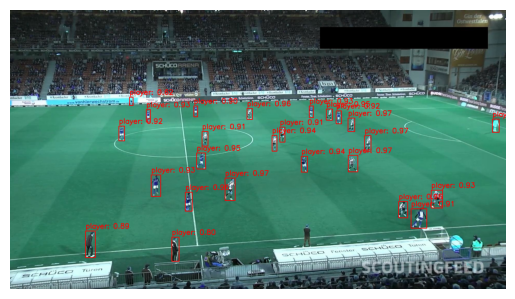

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


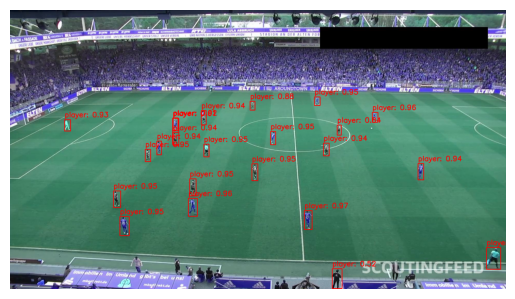

KeyboardInterrupt: 

In [5]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from src.utils import *

# Kreiramo dataset instancu i dataloader
dataset2 = CustomVOCDataset(root='datasetovi\dataset1.zip_sredjen\test', CLASSES=CLASSES, transforms=transform)
data_loader2 = DataLoader(dataset2, batch_size=1, shuffle=True, num_workers=4, collate_fn=my_collate_fn)

model.eval()
# Pokrenemo detektovanje nad datasetom koji smo load-ovali
for images, targets in data_loader2:
    images = list(img.to(device) for img in images)

    with torch.no_grad():
        prediction = model(images)

    for img, pred in zip(images, prediction):
        plot_image_with_boxes(img, pred['boxes'], pred['labels'], pred['scores'], CLASSES)